In [19]:
import numpy as np
import pandas as pd
from scipy.sparse.linalg import spsolve
from scipy import sparse
import matplotlib.pyplot as plt 

In [3]:
artists = pd.read_csv("hw2-bundle/hw2-bundle/implicit_feedback/data/artists.txt", sep="\t")
user_artists = pd.read_csv("hw2-bundle/hw2-bundle/implicit_feedback/data/user_artists.txt", sep="\t")
user_artists_small = pd.read_csv("hw2-bundle/hw2-bundle/implicit_feedback/data/user_artists_small.txt", sep="\t")

In [4]:
artists.head(3)

,artistID,name
0,0,MALICE MIZER
1,1,Diary of Dreams
2,2,Carpathian Forest


In [5]:
user_artists.head(3)

,userID,artistID,interactions
0,0,45,13883
1,0,46,11690
2,0,47,11351


In [6]:
user_artists_small

,userID,artistID,interactions
0,0,45,13883
1,0,46,11690
2,0,47,11351
3,0,48,10300
4,0,49,8983
...,...,...,...
260,94,75,73
261,94,83,45
262,95,59,194
263,96,7,1513


In [7]:
def ALS(X, Y, P, C, m, n, f, lamda, MAX_ITER = 100):
    """"
    X: initial user matrix
    Y: initial item matrix
    P: preference matrix
    C: confidence matrix
    """
    # objective function
    def objective(X, Y, C, P, lam):
        return (C.multiply((P - X @ Y.T).power(2))).sum() + lam * ((X.power(2)).sum() + (Y.power(2)).sum())
    
    # construct lambda * I
    # YOUR CODE HERE
    C_arr = C.toarray()

    lamda_eye = lamda * sparse.eye(f)
    objectives = np.zeros(MAX_ITER + 1)
    user_0_rec = np.zeros((MAX_ITER + 1, 2))
    user_20_rec = np.zeros((MAX_ITER + 1, 2))

    P_est = X.dot(Y.T)
    user_0_P = P_est[0,:].toarray().reshape(-1)
    first_rec = np.argmax(user_0_P)
    user_0_P[first_rec] = -np.infty
    second_rec = np.argmax(user_0_P)
    user_0_rec[0, 0] = first_rec
    user_0_rec[0, 1] = second_rec

    user_20_P = P_est[20,:].toarray().reshape(-1)
    first_rec = np.argmax(user_20_P)
    user_20_P[first_rec] = -np.infty
    second_rec = np.argmax(user_20_P)
    user_20_rec[0, 0] = first_rec
    user_20_rec[0, 1] = second_rec

    objectives[0] = objective(X, Y, C, P, lamda)
    
    print(f"At iteration 0, the objective is {objectives[0]}.")

    for t in range(MAX_ITER):
        # update item matrix
        # YOUR CODE HERE
        xTx = X.T.dot(X)
        for item in range(n):
            p_i = P[:, item]
            C_i_I = sparse.diags(C_arr[:, item] - 1) # the sparse matrix: C_i - I
            left = xTx + X.T.dot(C_i_I).dot(X) + lamda_eye	# please use the trick in spec 
            right = X.T.dot(C_i_I).dot(p_i) + X.T.dot(p_i)  # please use the trick in spec 
            y_i = spsolve(left, right)
            Y[item] = y_i
        
        # update user matrix   
        # YOUR CODE HERE     	
        yTy = Y.T.dot(Y)
        for user in range(m):
            p_u = P[user, :]
            C_u_I = sparse.diags(C_arr[user, :] - 1) # the sparse matrix: C_u - I
            left = yTy + Y.T.dot(C_u_I).dot(Y) + lamda_eye	   # please use the trick in spec 
            right = Y.T.dot(C_u_I).dot(p_u.T) + Y.T.dot(p_u.T) # please use the trick in spec  
            x_u = spsolve(left, right)
            X[user] = x_u
        
        P_est = X.dot(Y.T)
        user_0_P = P_est[0,:].toarray().reshape(-1)
        first_rec = np.argmax(user_0_P)
        user_0_P[first_rec] = -np.infty
        second_rec = np.argmax(user_0_P)
        user_0_rec[t + 1, 0] = first_rec
        user_0_rec[t + 1, 1] = second_rec

        user_20_P = P_est[20,:].toarray().reshape(-1)
        first_rec = np.argmax(user_20_P)
        user_20_P[first_rec] = -np.infty
        second_rec = np.argmax(user_20_P)
        user_20_rec[t + 1, 0] = first_rec
        user_20_rec[t + 1, 1] = second_rec
        
        objectives[t + 1] = objective(X, Y, C, P, lamda)
        print(f"At iteration {t + 1}, the objective is {objectives[t + 1]}.")
    return X, Y, objectives, user_0_rec, user_20_rec

In [12]:
m = 1882
n = 3000
# m = 100
# n = 100
f = 3
lamda = 0.01

X = sparse.csr_matrix(np.zeros((m, f)) + 0.5)  
Y = sparse.csr_matrix(np.zeros((n, f))) 

# construct the preference matrix and confidence matrix
# YOUR CODE HERE
# data = user_artists_small
data = user_artists   

R = sparse.csr_matrix((data["interactions"], (data["userID"], data["artistID"])), 
                        shape=(m,n))
P = (R > 0)
alpha = np.sum(P) / (m * n - np.sum(P))
C = sparse.csr_matrix(1 + alpha * R.toarray())

result = ALS(X, Y, P, C, m, n, f, lamda)

At iteration 0, the objective is 685918.6402882535.


c:\Users\Wenhao\miniconda3\lib\site-packages\scipy\sparse\_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


At iteration 1, the objective is 320028.2019211311.
At iteration 2, the objective is 311709.3671542023.
At iteration 3, the objective is 276100.4268775552.
At iteration 4, the objective is 255598.40479540534.
At iteration 5, the objective is 249615.74040297852.
At iteration 6, the objective is 246899.78150121708.
At iteration 7, the objective is 245130.84522853734.
At iteration 8, the objective is 243732.55160143416.
At iteration 9, the objective is 242535.21579837333.
At iteration 10, the objective is 241550.0176528396.
At iteration 11, the objective is 240936.98024335847.
At iteration 12, the objective is 240525.4898779375.
At iteration 13, the objective is 240214.19298377432.
At iteration 14, the objective is 239950.58109239078.
At iteration 15, the objective is 239707.02491037763.
At iteration 16, the objective is 239467.6758351776.
At iteration 17, the objective is 239219.7505328483.
At iteration 18, the objective is 238953.8571977451.
At iteration 19, the objective is 238664.1106

In [13]:
X, Y, objectives, user_0_rec, user_20_rec = result

In [18]:
print(f"The sparsity ratio is {alpha}")
print(f"The initial objective is {objectives[0]}")
print(f"The objective after the 1st iteration is {objectives[1]}")
print(f"The top 2 artist recommendations for user 0 after the 1st iteration is {user_0_rec[1]}")
print(f"The top 2 artist recommendations for user 0 after the 100th iteration is {user_0_rec[100]}")
print(f"The top 2 artist recommendations for user 20 after the 1st iteration is {user_20_rec[1]}")
print(f"The top 2 artist recommendations for user 20 after the 100th iteration is {user_20_rec[100]}")

The sparsity ratio is 0.011265055687640536
The initial objective is 685918.6402882535
The objective after the 1st iteration is 320028.2019211311
The top 2 artist recommendations for user 0 after the 1st iteration is [283.  83.]
The top 2 artist recommendations for user 0 after the 100th iteration is [ 181. 1089.]
The top 2 artist recommendations for user 20 after the 1st iteration is [283.  83.]
The top 2 artist recommendations for user 20 after the 100th iteration is [ 66. 221.]


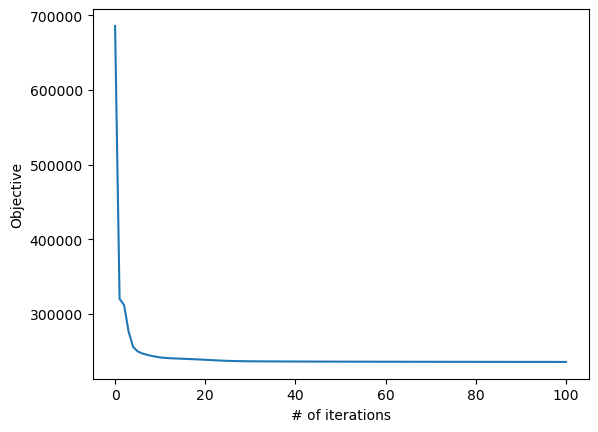

In [21]:
fig, ax = plt.subplots()
ax.plot(np.arange(101), objectives)
ax.set_xlabel("# of iterations")
ax.set_ylabel("Objective")
plt.show()

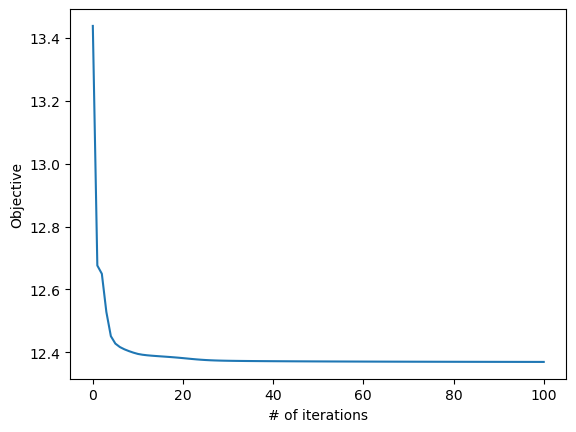

In [24]:
fig, ax = plt.subplots()
ax.plot(np.arange(101), objectives)
ax.set_xlabel("# of iterations")
ax.set_ylabel("Objective")
ax.set_yscale("log")
plt.show()